https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification


In [1]:

import torch
from torch import nn
from torch.optim import Adam
import librosa
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time
from skimage.transform import resize
%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
data_df = pd.read_csv('files_paths.csv')
data_df.head(2)

,FilePath,Class
0,./Dataset/Mohammed_Aluhaidan/lohaidan_171.wav,Mohammed_Aluhaidan
1,./Dataset/Mohammed_Aluhaidan/lohaidan_159.wav,Mohammed_Aluhaidan


In [4]:
data_df['FilePath'] = "C:/Users/danie/OneDrive/Desktop/Data_science/ML/Audio Classification/Dataset" + data_df['FilePath'].str[1:]

In [5]:
pd.set_option('display.max_colwidth',None)

In [6]:
data_df.head(1)

,FilePath,Class
0,C:/Users/danie/OneDrive/Desktop/Data_science/ML/Audio Classification/Dataset/Dataset/Mohammed_Aluhaidan/lohaidan_171.wav,Mohammed_Aluhaidan


In [15]:
data_df.Class.value_counts().index.tolist()

[10, 9, 1, 11, 3, 4, 5, 2, 7, 8, 0, 6]

Data shape is :(6687, 2)
Class distribution:Class
10    696
9     688
1     648
11    576
3     576
4     576
5     576
2     504
7     480
8     456
0     456
6     455
Name: count, dtype: int64



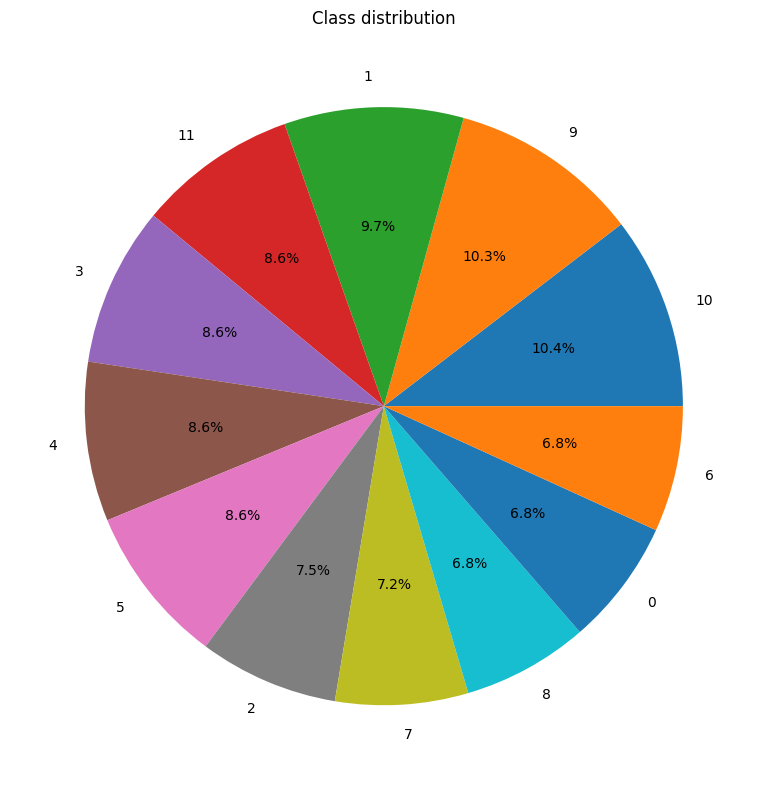

In [14]:
print(f'Data shape is :{data_df.shape}')
print(f'Class distribution:{data_df.Class.value_counts()}')
print()
plt.figure(figsize=(8,8))
plt.pie(data_df['Class'].value_counts(),labels=data_df['Class'].value_counts().index,autopct='%1.1f%%')

plt.title('Class distribution')
plt.tight_layout()
plt.show()

In [9]:
label_encoder = LabelEncoder()
data_df['Class']=label_encoder.fit_transform(data_df['Class'])

In [10]:
train = data_df.sample(frac=.7,random_state=7)
test = data_df.drop(train.index)

val = test.sample(frac=.5,random_state=7)
test = test.drop(val.index)

In [11]:
class CustomAudioDataSet(Dataset):
    def __init__(self,dataframe):
        self.dataframe= dataframe
        self.labels = torch.Tensor(list(dataframe['Class'])).type(torch.LongTensor).to(device)
        self.audios = [torch.Tensor(self.get_spectogram(path)).type(torch.FloatTensor) for path in dataframe['FilePath']]
        
    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self,index):
        img_path = self.dataframe.iloc[index,0]
        label  = torch.tensor(self.labels[index]).to(device)
        audio = self.audios[index].unsqueeze(0).to(device)
        return audio,label
        
    def get_spectogram(self,file_path):
        sr = 22050
        duration =5
        img_heigh= 128
        img_width = 256
        
        signal , sr =librosa.load(file_path,sr=sr,duration=duration)
        
        specto = librosa.feature.melspectrogram(y=signal,sr=sr,n_fft=2048,hop_length=512,n_mels=128)
        
        specto_db = librosa.power_to_db(specto,ref=np.max)
        
        spec_resized = librosa.util.fix_length(specto_db,size=(duration+sr)//512+1)
        spec_resized = resize(spec_resized,(img_heigh,img_width),anti_aliasing=True)
        
        return spec_resized

In [12]:
train_dataset = CustomAudioDataSet(dataframe=train)
val_dataset = CustomAudioDataSet(dataframe=val)
test_dataset = CustomAudioDataSet(dataframe=test)

In [28]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 25

In [29]:
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [63]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1,16,kernel_size=3,padding=1)
        self.conv2=nn.Conv2d(16,32,kernel_size=3,padding=1)
        self.conv3=nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.pooling = nn.MaxPool2d(2,2)
        self.ReLu =nn.ReLU()
        self.flatten= nn.Flatten()
        self.linear1 = nn.Linear((64*16*32),4096)
        self.linear2 = nn.Linear(4096,1024)
        self.linear3 = nn.Linear(1024,512)
        self.output = nn.Linear(512,len(data_df['Class'].unique()))
        self.dropout = nn.Dropout(.5)
        
    def forward(self,x):
        x= self.conv1(x)
        x = self.pooling(x)
        x=self.ReLu(x)
        x=self.conv2(x)
        x=self.pooling(x)
        x=self.ReLu(x)
        x=self.conv3(x)
        x=self.pooling(x)
        x=self.ReLu(x)
        
        #x=x.view(x.size(0),-1)
        x=self.flatten(x)
        x=self.linear1(x)
        x=self.ReLu(x)
        x=self.dropout(x)
        x=self.linear2(x)
        x=self.ReLu(x)
        x=self.dropout(x)
        x=self.linear3(x)
        x=self.ReLu(x)  
        x=self.dropout(x)
        x=self.output(x)
        
        return x

In [64]:
model = Net().to(device)

In [65]:
from torchsummary import summary

In [70]:
for x, y in train_loader:
    print(x.shape)
    break


torch.Size([16, 1, 128, 256])


C:\Users\danie\AppData\Local\Temp\ipykernel_6192\3666023126.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label  = torch.tensor(self.labels[index]).to(device)


In [66]:
summary(model,(1,128,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
         MaxPool2d-2          [-1, 16, 64, 128]               0
              ReLU-3          [-1, 16, 64, 128]               0
            Conv2d-4          [-1, 32, 64, 128]           4,640
         MaxPool2d-5           [-1, 32, 32, 64]               0
              ReLU-6           [-1, 32, 32, 64]               0
            Conv2d-7           [-1, 64, 32, 64]          18,496
         MaxPool2d-8           [-1, 64, 16, 32]               0
              ReLU-9           [-1, 64, 16, 32]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                 [-1, 4096]     134,221,824
             ReLU-12                 [-1, 4096]               0
          Dropout-13                 [-1, 4096]               0
           Linear-14                 [-

In [71]:
criterion = nn.CrossEntropyLoss()
optimazer= Adam(model.parameters(),lr=LR)


In [ ]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_acc_val = 0
    model.train()
    total_loss_val = 0
    total_loss_train=0
    
    for input,label in train_loader:
        outputs = model(input)
        train_loss = criterion(outputs,label)
        total_loss_train += train_loss.item()
        train_loss.backward()
        
        train_acc = (torch.argmax(outputs,axis=1) == label).sum().item()
        total_acc_train += train_acc
        optimazer.step()
        optimazer.zero_grad()
        
    with torch.no_grad():
        model.eval()
        for inputs,label in val_loader:
            outputs =model(inputs)
            val_loss = criterion(outputs,label)
            total_loss_val += val_loss.item()
            val_acc = (torch.argmax(outputs,axis=1)==label).sum().item()
            total_acc_val += val_acc
            
    total_loss_train_plot.append(round(total_loss_train/len(train_loader),4))
    total_loss_validation_plot.append(round(total_loss_val/len(val_loader),4))
    
    total_acc_train_plot.append(round(total_acc_train/len(train_dataset)*100,4))
    total_acc_validation_plot.append(round(total_acc_val/len(val_dataset)*100,4))

    print(f'Epoch:{epoch+1}/{EPOCHS} Train Loss :{total_loss_train_plot[epoch]} Accuracy Score: {total_acc_train_plot[epoch]}%')
    print(f'Epoch:{epoch+1}/{EPOCHS} Validation Loss:{total_loss_validation_plot[epoch]} Accuracy Score: {total_acc_validation_plot[epoch]}%')


C:\Users\danie\AppData\Local\Temp\ipykernel_6192\3666023126.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label  = torch.tensor(self.labels[index]).to(device)


Epoch:1/25 Train Loss :1.0028 Accuracy Score: 67.1651%
Epoch:1/25 Validation Loss:80.1595 Accuracy Score: 80.1595%
Epoch:2/25 Train Loss :0.4514 Accuracy Score: 85.3023%
Epoch:2/25 Validation Loss:84.4467 Accuracy Score: 84.4467%
Epoch:3/25 Train Loss :0.2447 Accuracy Score: 92.3093%
Epoch:3/25 Validation Loss:93.4197 Accuracy Score: 93.4197%
Epoch:4/25 Train Loss :0.1619 Accuracy Score: 95.1506%
Epoch:4/25 Validation Loss:90.7278 Accuracy Score: 90.7278%
Epoch:5/25 Train Loss :0.1081 Accuracy Score: 96.8169%
Epoch:5/25 Validation Loss:94.4167 Accuracy Score: 94.4167%
Epoch:6/25 Train Loss :0.0694 Accuracy Score: 97.9064%
Epoch:6/25 Validation Loss:94.317 Accuracy Score: 94.317%
Epoch:7/25 Train Loss :0.0455 Accuracy Score: 98.6114%
Epoch:7/25 Validation Loss:92.7218 Accuracy Score: 92.7218%
Epoch:8/25 Train Loss :0.0435 Accuracy Score: 98.6541%
Epoch:8/25 Validation Loss:93.8185 Accuracy Score: 93.8185%
Epoch:9/25 Train Loss :0.03 Accuracy Score: 99.1028%
Epoch:9/25 Validation Loss:95

In [78]:
with torch.no_grad():
    model.eval()
    total_loss_test = 0
    total_acc_test = 0
    
    for input,labels in test_loader:
        prediction = model(input)
        acc = (torch.argmax(prediction,axis=1) == labels).sum().item()
        
        total_acc_test += acc
        
print(f'Total acc score is :{round(total_acc_test/len(test_dataset)*100,2)}%')

C:\Users\danie\AppData\Local\Temp\ipykernel_6192\3666023126.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label  = torch.tensor(self.labels[index]).to(device)


Total acc score is :96.81%


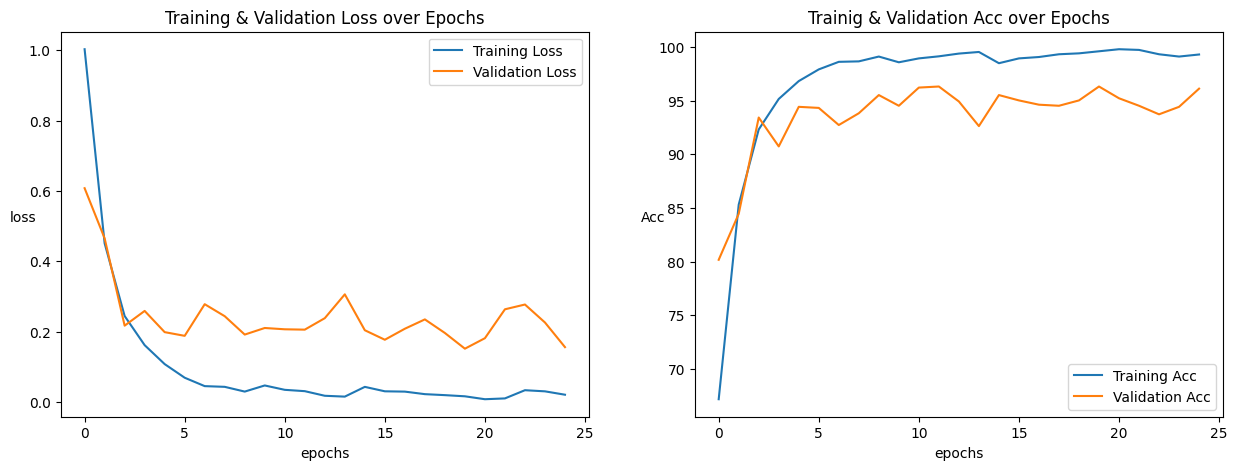

In [79]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(total_loss_train_plot,label='Training Loss')
plt.plot(total_loss_validation_plot,label='Validation Loss')
plt.title('Training & Validation Loss over Epochs')
plt.xlabel('epochs')
plt.ylabel('loss',rotation=0)
plt.legend()
plt.subplot(1,2,2)
plt.plot(total_acc_train_plot,label='Training Acc')
plt.plot(total_acc_validation_plot,label='Validation Acc')
plt.title('Trainig & Validation Acc over Epochs')
plt.xlabel('epochs')
plt.ylabel('Acc',rotation =0)
plt.legend()
